We generate a bunch of points which are labeled plus or minus. The plus category has 10 points, while the minus category has 15. The points are generated at random, you may see an overlap between them.

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numpy import linalg as lin


import numpy.random as npr


Xplusx = npr.normal(1,2,(10,1))
Xplusy = npr.normal(1,3,(10,1))
Xplusz = npr.normal(1,5,(10,1))

Xplus = np.hstack((Xplusx,Xplusy,Xplusz))
yplus = np.ones((10,1))
Xminus = npr.normal(-1,2,(15,3))
yminus = -np.ones((15,1))


We plot the points below, the color of the points matches their class. The mean of the set of the points in the "plus" category is muplus, while the mean of the set of points in the minus category is muminus. The figure below also shows the line through muplus and muminus in blue. muplus is marked in orange and muminus in green.

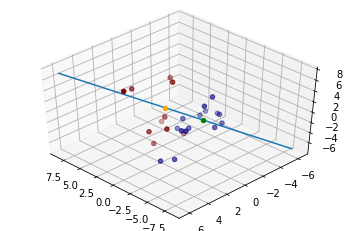

In [188]:

X = np.vstack((Xplus,Xminus))
y = np.vstack((yplus,yminus)).reshape(25,)
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.set_cmap('jet')
ax.scatter(X[:,0],X[:,1],X[:,2],c=100*y)

muplus = np.mean(Xplus, axis=0)
muminus = np.mean(Xminus, axis=0)


mu = np.vstack((muplus,muminus))
mu12 = np.array([[1,-1]]) @ mu 
mu12 = mu12.reshape(3,1)

muline = np.array([[-3,0],[3,0]]) @ np.array([[1,-1],[0,0]]) @ mu
ax.plot(muline[:,0],muline[:,1],muline[:,2])

muplusproj = mu12 @ mu12.T @ muplus.reshape(3,1)/(mu12.T @ mu12)
muminusproj = mu12 @ mu12.T @ muminus.reshape(3,1)/(mu12.T @ mu12)

ax.scatter(muplusproj[0],muplusproj[1],muplusproj[2],c=['orange'])
ax.scatter(muminusproj[0],muminusproj[1],muminusproj[2],c=['green'])


ax.view_init(45,135)




Suppose we decide to ignore the 3 dimensions. Instead, we project all the points onto the direction of the line connecting muplus and muminus (so a line parallel to one connecting muplus and muminus, but through the origin). This, as you know, is a 1-dimensional linear space. 

In the MNIST dataset, we would have projected all 60,000 points in the 784 dimensional space on to one line, a 1-dimensional space. 

We could project onto any direction (1-d space) of course, and we will pick a better direction below.

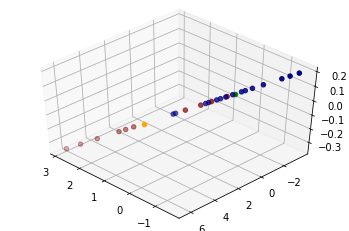

In [182]:
projections = mu12 @ mu12.T @ X.T/(mu12.T @ mu12)

projections = projections.T
muplusproj = mu12 @ mu12.T @ muplus.reshape(3,1)/(mu12.T @ mu12)
muminusproj = mu12 @ mu12.T @ muminus.reshape(3,1)/(mu12.T @ mu12)


fig = plt.figure()
ax = plt.axes(projection='3d')
plt.set_cmap('jet')

ax.scatter(muplusproj[0],muplusproj[1],muplusproj[2],c=['orange'])
ax.scatter(muminusproj[0],muminusproj[1],muminusproj[2],c=['green'])
ax.scatter(projections[:,0], projections[:,1],projections[:,2],c=100*y)

ax.view_init(45,135)


As you now see, the projections of the two classes are now somewhat mixed up. You can also see the projections of the means (the orange and green points), as well as the projections of the points in the two classes, the red and blue points. There is overlap between the classes. But since we projected in the direction of the line connecting muplus and muminus, the means are as far apart as they could possibly be in any one-dimensional projection (why?). 

It is desirable that the means of the two classes be spaced as far apart as possible for good classification. But we should also keep in mind the spread of the (projections of) points in each class. Here, though the means are spaced apart, there may be overlap between the classes as well (since the data is randomly generated, you may see a heavy overlap or if you are lucky, a lighter overlap).

The question then is which direction works best. You can try different directions below:

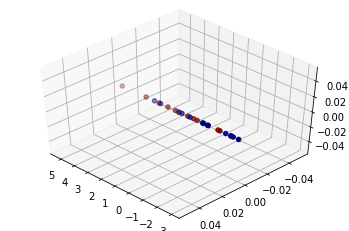

In [183]:
direction = np.array([-1,0,0]).reshape(3,1)

projections = direction @ direction.T @ X.T/(direction.T @ direction)

projections = projections.T

muplusproj = direction @ direction.T @ muplus.reshape(3,1)/(direction.T @ direction)
muminusproj = direction @ direction.T @ muminus.reshape(3,1)/(direction.T @ direction)

fig = plt.figure()
ax = plt.axes(projection='3d')
plt.set_cmap('jet')

ax.scatter(muplusproj[0],muplusproj[1],muplusproj[2],c=['orange'])
ax.scatter(muminusproj[0],muminusproj[1],muminusproj[2],c=['green'])
ax.scatter(projections[:,0], projections[:,1],projections[:,2],c=100*y)


ax.view_init(45,135)


We want to space out the means as best as possible, but that is not the only thing to pay attention to. We want to only search among directions such that the scattering within classes to be less than some number (next class, we will see how to quantify this). The direction of the line between muplus and muminus may or may not satisfy the intra-class scattering constraint (more often than not, it will not). So now we have a constrained optimization problem, the theme of several formulations in the next few classes.

But here is where something miraculous happens. The best direction is actually just the vector of coefficients of the Linear Regression problem where we fit the targets, +/-1 to the data, just as our "naive" approach to MNIST classification. So it isn't as naive after all---the approach picks the best one dimensional space for us to work in!

This direction is usually different from that of the line joining muplus and muminus. You may still see some overlap, but it is the direction that optimizes the dual constraints---maximizing separation between the class-means while minimizing the intra-class spread.

The angle between the vector of regression coefficients and the
 direction of the line joining muplus and muminus is (in degrees):  4.314496789838269


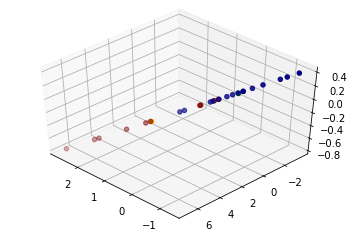

In [186]:
from sklearn.linear_model import LinearRegression
from math import acos as acos
from math import pi as pi

reg = LinearRegression(fit_intercept = True).fit(X,y)

direction = reg.coef_

print('The angle between the vector of regression coefficients and the\n direction of the line joining muplus and muminus is (in degrees): ', acos((direction.T @ mu12)/np.sqrt((direction.T @ direction)* (mu12.T @ mu12)))*180/pi)

direction = direction.reshape(3,1)
projections = direction @ direction.T @ X.T/(direction.T @ direction)

projections = projections.T

muplusproj = direction @ direction.T @ muplus.reshape(3,1)/(direction.T @ direction)
muminusproj = direction @ direction.T @ muminus.reshape(3,1)/(direction.T @ direction)

fig = plt.figure()
ax = plt.axes(projection='3d')
plt.set_cmap('jet')

ax.scatter(muplusproj[0],muplusproj[1],muplusproj[2],c=['orange'])
ax.scatter(muminusproj[0],muminusproj[1],muminusproj[2],c=['green'])
ax.scatter(projections[:,0], projections[:,1],projections[:,2],c=100*y)


ax.view_init(45,135)
